# MCMAC results analysis

・'age' is absolute time

・'sep.kpc' is projected distance between two clusters

・'merger' shows the clusters is pre-merger or not

・'TSC_Catalog' shows Time Since Collision from Galaxy Cluster Merger Catalog. 

 We can calculate 
 
 TTC by "(1st apocentric passage's absolute time) - (TSC at 1st apocentric passage) - (dataframe's age) "
 
and 

TSC "(dataframe's age) - { (1st apocentric passage's absolute time) - (TSC at 1st apocentric passage)}".
 
 For simple dataframe, we replaced TTC to TSC by putting minus symbol
 
・'TSC0' shows Time Since Collision from MCMAC-pre-merger and MCMAC-post-merger

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re


In [2]:
results_default = []
results_weaklensing = []

In [3]:
def extract_parameters(filename):
    # Define the pattern to extract the parameters from the filename
    pattern = r'zh_(\d+)to(\d+)_b([\d.]+)_z_MCMAC.txt'
    
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    
    if match:
        # Extract the parameters
        param1 = match.group(1)
        param2 = match.group(2)
        b_value = match.group(3)
        
        # Format the parameters as "1:1 (b=0)"
        formatted_params = f"{param1}:{param2} (b={b_value})"
        
        return formatted_params
    else:
        return None

def plotImage(filename_default, filename_weaklensing, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time):
    df_default = pd.read_csv(filename_default, sep='\t')
    df_selected_default = df_default[['age','sep.kpc','merger', 'TSC_Catalog', 'TSC0', 'TSC0.lower', 'TSC0.upper']]

    df_weaklensing = pd.read_csv(filename_weaklensing, sep='\t')
    df_selected_weaklensing = df_weaklensing[['age','sep.kpc','merger', 'TSC_Catalog', 'TSC0', 'TSC0.lower', 'TSC0.upper']]

    # When we replace Time Till Collision to Time Since Collision, we need to set minus.
    # We got Time Till Collision by using MCMAC-pre code.
    df_selected_default.loc[df_selected_default['merger'] == 'pre', ['TSC0', 'TSC0.lower', 'TSC0.upper']] *= -1
    df_selected_weaklensing.loc[df_selected_weaklensing['merger'] == 'pre', ['TSC0', 'TSC0.lower', 'TSC0.upper']] *= -1

    # 相対誤差の計算
    df_selected_default = df_selected_default.copy()
    df_selected_default['Absolute Residual'] = df_selected_default['TSC0'] - df_selected_default['TSC_Catalog']
    # df_selected_default.loc[:, 'Absolute Residual'] = df_selected_default['TSC0'] - df_selected_default['TSC_Catalog']
    df_selected_weaklensing = df_selected_weaklensing.copy()
    df_selected_weaklensing['Absolute Residual'] = df_selected_weaklensing['TSC0'] - df_selected_weaklensing['TSC_Catalog']
    # df_selected_weaklensing.loc[:, 'Absolute Residual'] = df_selected_weaklensing['TSC0'] - df_selected_weaklensing['TSC_Catalog']

    # プロットスタイルの設定
    plt.style.use('ggplot')

    # 図とグリッドスペックの作成
    fig = plt.figure(figsize=(12, 18))
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 3])

    # delta.t の範囲でフィルタリング
    df_zoomed = df_selected_default[(df_selected_default['TSC_Catalog'] >= -0.3) & (df_selected_default['TSC_Catalog'] <= 0.3)]
    df_zoomed_weaklensing = df_selected_weaklensing[(df_selected_weaklensing['TSC_Catalog'] >= -0.3) & (df_selected_weaklensing['TSC_Catalog'] <= 0.3)]

    # 最上部プロット (拡大図)
    ax_zoom = fig.add_subplot(gs[0])
    line_zoom1 = ax_zoom.scatter(df_zoomed['TSC_Catalog'], df_zoomed['TSC_Catalog'], label='TSC from Catalog', color='blue', s=64, marker='^')
    line_zoom2 = ax_zoom.errorbar(df_zoomed['TSC_Catalog'], df_zoomed['TSC0'], yerr=[np.abs(df_zoomed['TSC0'] - df_zoomed['TSC0.lower']), np.abs(df_zoomed['TSC0.upper'] - df_zoomed['TSC0'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='TSC from MCMAC')
    line_zoom3 = ax_zoom.errorbar(df_zoomed_weaklensing['TSC_Catalog'], df_zoomed_weaklensing['TSC0'], yerr=[np.abs(df_zoomed_weaklensing['TSC0'] - df_zoomed_weaklensing['TSC0.lower']), np.abs(df_zoomed_weaklensing['TSC0.upper'] - df_zoomed_weaklensing['TSC0'])], fmt='o', ecolor='green', capsize=5, markersize=6, color='green', label='TSC from MCMAC with weak lensing')

    # 縦の点線を追加
    ax_zoom.axvline(color='black', linestyle='--')
    ax_zoom.axhline(color='black', linestyle='--')


    ax_zoom.set_xlabel('delta.t (TSC from catalogue)')
    ax_zoom.set_ylabel('TSC from Catalog')
    ax_zoom.set_xlim(zoom_x_range[0], zoom_x_range[1])
    ax_zoom.set_ylim(zoom_y_range[0], zoom_y_range[1])

    # 二つ目のy軸としてTSC from MCMACを追加
    ax_zoom2 = ax_zoom.twinx()
    ax_zoom2.set_ylabel('TSC from MCMAC')
    ax_zoom2.set_ylim(zoom_y_range[0], zoom_y_range[1])

    lines_zoom = [line_zoom1, line_zoom2, line_zoom3]
    labels_zoom = [l.get_label() for l in lines_zoom]
    ax_zoom.legend(lines_zoom, labels_zoom, loc='upper left')

    # 上部プロット
    ax1 = fig.add_subplot(gs[1])
    line1 = ax1.scatter(df_selected_default['age'], df_selected_default['TSC_Catalog'], label='TSC from Catalog', color='blue', s=64, marker='^')
    ax1.set_xlabel('Absolute age (Gyr)')
    ax1.set_ylabel('TSC from Catalog')
    ax1.set_xlim(plot1_x_range[0], plot1_x_range[1])
    ax1.set_ylim(plot1_y_range[0], plot1_y_range[1])
    ax1.axvline(x=absolute_merge_time, color='black', linestyle='--')
    ax1.axhline(color='black', linestyle='--')

    ax2 = ax1.twinx()
    line2 = ax2.errorbar(df_selected_default['age'], df_selected_default['TSC0'], yerr=[np.abs(df_selected_default['TSC0'] - df_selected_default['TSC0.lower']), np.abs(df_selected_default['TSC0.upper'] - df_selected_default['TSC0'])], fmt='o', ecolor='red', capsize=5, markersize=6, color='red', label='TSC from MCMAC')
    line3 = ax2.errorbar(df_selected_weaklensing['age'], df_selected_weaklensing['TSC0'], yerr=[np.abs(df_selected_weaklensing['TSC0'] - df_selected_weaklensing['TSC0.lower']), np.abs(df_selected_weaklensing['TSC0.upper'] - df_selected_weaklensing['TSC0'])], fmt='o', ecolor='green', capsize=5, markersize=6, color='green', label='TSC from MCMAC with weak lensing')

    ax2.set_ylabel('TSC from MCMAC')
    ax2.set_ylim(plot1_y_range[0], plot1_y_range[1])

    ax7 = ax1.twiny()
    ax7.set_xlim(ax1.get_xlim())
    ax7.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['TSC_Catalog'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax7.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax7.set_xlabel('delta.t (TSC from catalogue)')

    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # 中部プロット
    ax3 = fig.add_subplot(gs[2])
    line4 = ax3.plot(df_selected_default['age'], df_selected_default['Absolute Residual'], 'r-', label='Default', marker='o', markersize=5)
    line5 = ax3.plot(df_selected_weaklensing['age'], df_selected_weaklensing['Absolute Residual'], '-', label='Weak lensing', marker='o', markersize=5, color='green')

    ax3.set_xlabel('Absolute age (Gyr)')
    ax3.set_ylabel('Absolute Residual (Gyr)')
    ax3.set_xlim(plot2_x_range[0], plot2_x_range[1])
    ax3.set_ylim(plot2_y_range[0], plot2_y_range[1])
    ax3.axhline(color='black', linestyle='--')
    ax3.axvline(x=absolute_merge_time, color='black', linestyle='--')


    ax6 = ax3.twiny()
    ax6.set_xlim(ax3.get_xlim())
    ax6.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['TSC_Catalog'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax6.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax6.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax6.axvline(x=0.00, color='black', linestyle='--')

    lines_mid = [line4[0], line5[0]]
    labels_mid = [l.get_label() for l in lines_mid]
    ax3.legend(lines_mid, labels_mid, loc='upper left')

    # 下部プロット
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(df_selected_default['age'], df_selected_default['sep.kpc'], 'b-', label='Halo Separation', marker='o', markersize=5)
    ax4.set_xlabel('Absolute age (Gyr)')
    ax4.set_ylabel('Halo Separation (kpc)')
    ax4.set_xlim(plot3_x_range[0], plot3_x_range[1])
    ax4.set_ylim(plot3_y_range[0], plot3_y_range[1])
    ax4.axvline(x=absolute_merge_time, color='black', linestyle='--')


    ax5 = ax4.twiny()
    ax5.set_xlim(ax4.get_xlim())
    ax5.set_xticks(df_selected_default['age'][::4])
    relative_time_labels = [f'{val:.2f}' for val in df_selected_default['TSC_Catalog'].reindex(df_selected_default.index, fill_value=0)][::4]
    ax5.set_xticklabels(relative_time_labels, rotation=0, ha='center')
    ax5.set_xlabel('delta.t (TSC from catalogue)')

    # 縦の点線を第2x軸に追加
    ax5.axvline(x=0.00, color='black', linestyle='--')

    # Calculate metrics
    mae_default = mean_absolute_error(df_selected_default['TSC_Catalog'], df_selected_default['TSC0'])
    rmse_default = np.sqrt(mean_squared_error(df_selected_default['TSC_Catalog'], df_selected_default['TSC0']))
    r2_default = r2_score(df_selected_default['TSC_Catalog'], df_selected_default['TSC0'])

    mae_weaklensing = mean_absolute_error(df_selected_weaklensing['TSC_Catalog'], df_selected_weaklensing['TSC0'])
    rmse_weaklensing = np.sqrt(mean_squared_error(df_selected_weaklensing['TSC_Catalog'], df_selected_weaklensing['TSC0']))
    r2_weaklensing = r2_score(df_selected_weaklensing['TSC_Catalog'], df_selected_weaklensing['TSC0'])

    plt.tight_layout()
    plt.show()

    filename_default = extract_parameters(filename_default)
    # Print metrics
    print(f"Metrics for default:")
    print(f"MAE: {mae_default}")
    print(f"RMSE: {rmse_default}")
    print(f"R²: {r2_default}")
    results_default.append({
        "filename": filename_default,
        "MAE": mae_default,
        "RMSE": rmse_default,
        "R²": r2_default
    })

    filename_weaklensing = extract_parameters(filename_weaklensing)
    print(f"\nMetrics for weak lensing bias:")
    print(f"MAE: {mae_weaklensing}")
    print(f"RMSE: {rmse_weaklensing}")
    print(f"R²: {r2_weaklensing}")
    results_weaklensing.append({
        "filename": filename_weaklensing,
        "MAE": mae_weaklensing,
        "RMSE": rmse_weaklensing,
        "R²": r2_weaklensing
    })


## Mass ratio 1:1 b=0kpc

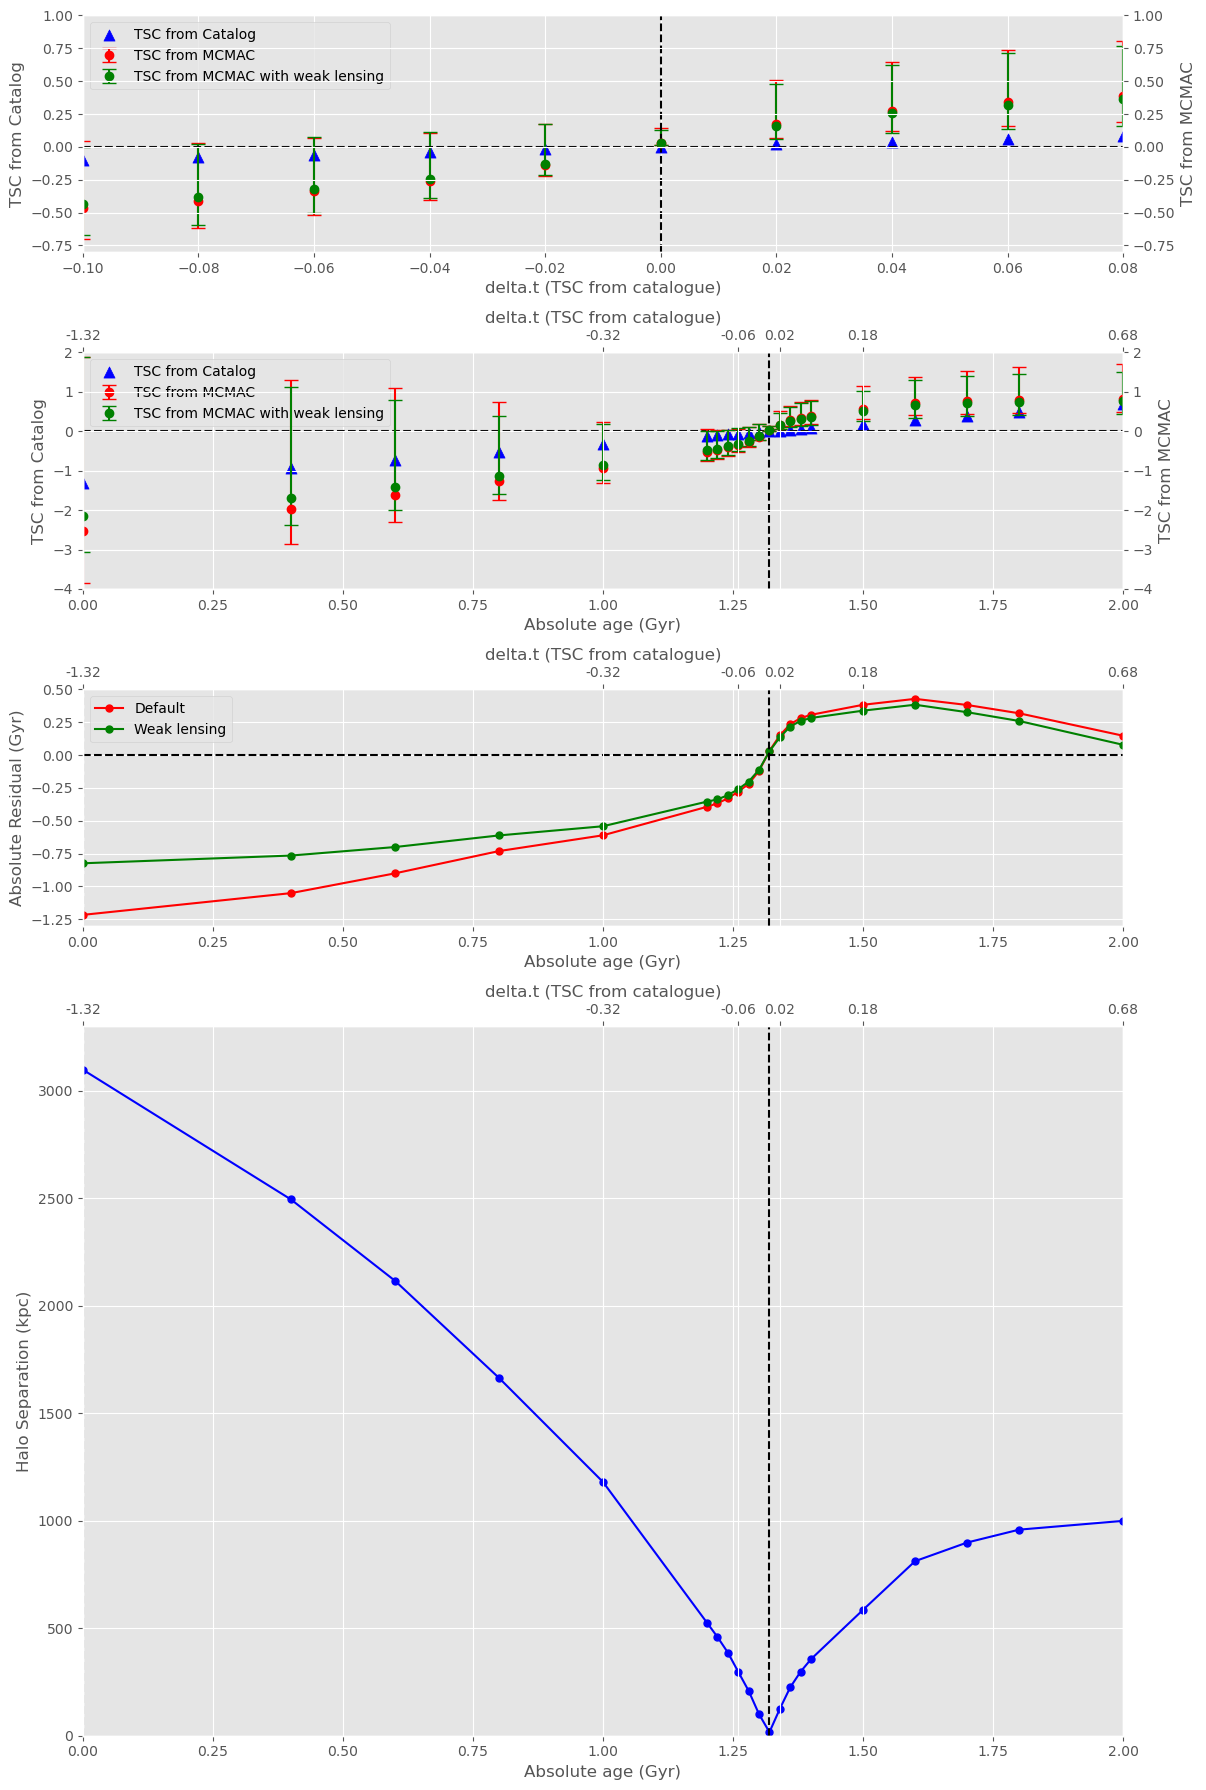

Metrics for default:
MAE: 0.4229308899465833
RMSE: 0.52046463433213
R²: -0.3284506371536038

Metrics for weak lensing bias:
MAE: 0.3487120010434708
RMSE: 0.40991848482279725
R²: 0.17594162390526147


In [4]:
filename_default = '../output_default/zh_1to1_b0_z_MCMAC.txt'
filename_20degree = '../output_weaklensing_bias/zh_1to1_b0_z_MCMAC.txt'

zoom_x_range = [-0.1, 0.08]
zoom_y_range = [-0.8, 1]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3300]
absolute_merge_time = 2 - 0.68

plotImage(filename_default, filename_20degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:1 b=500kpc

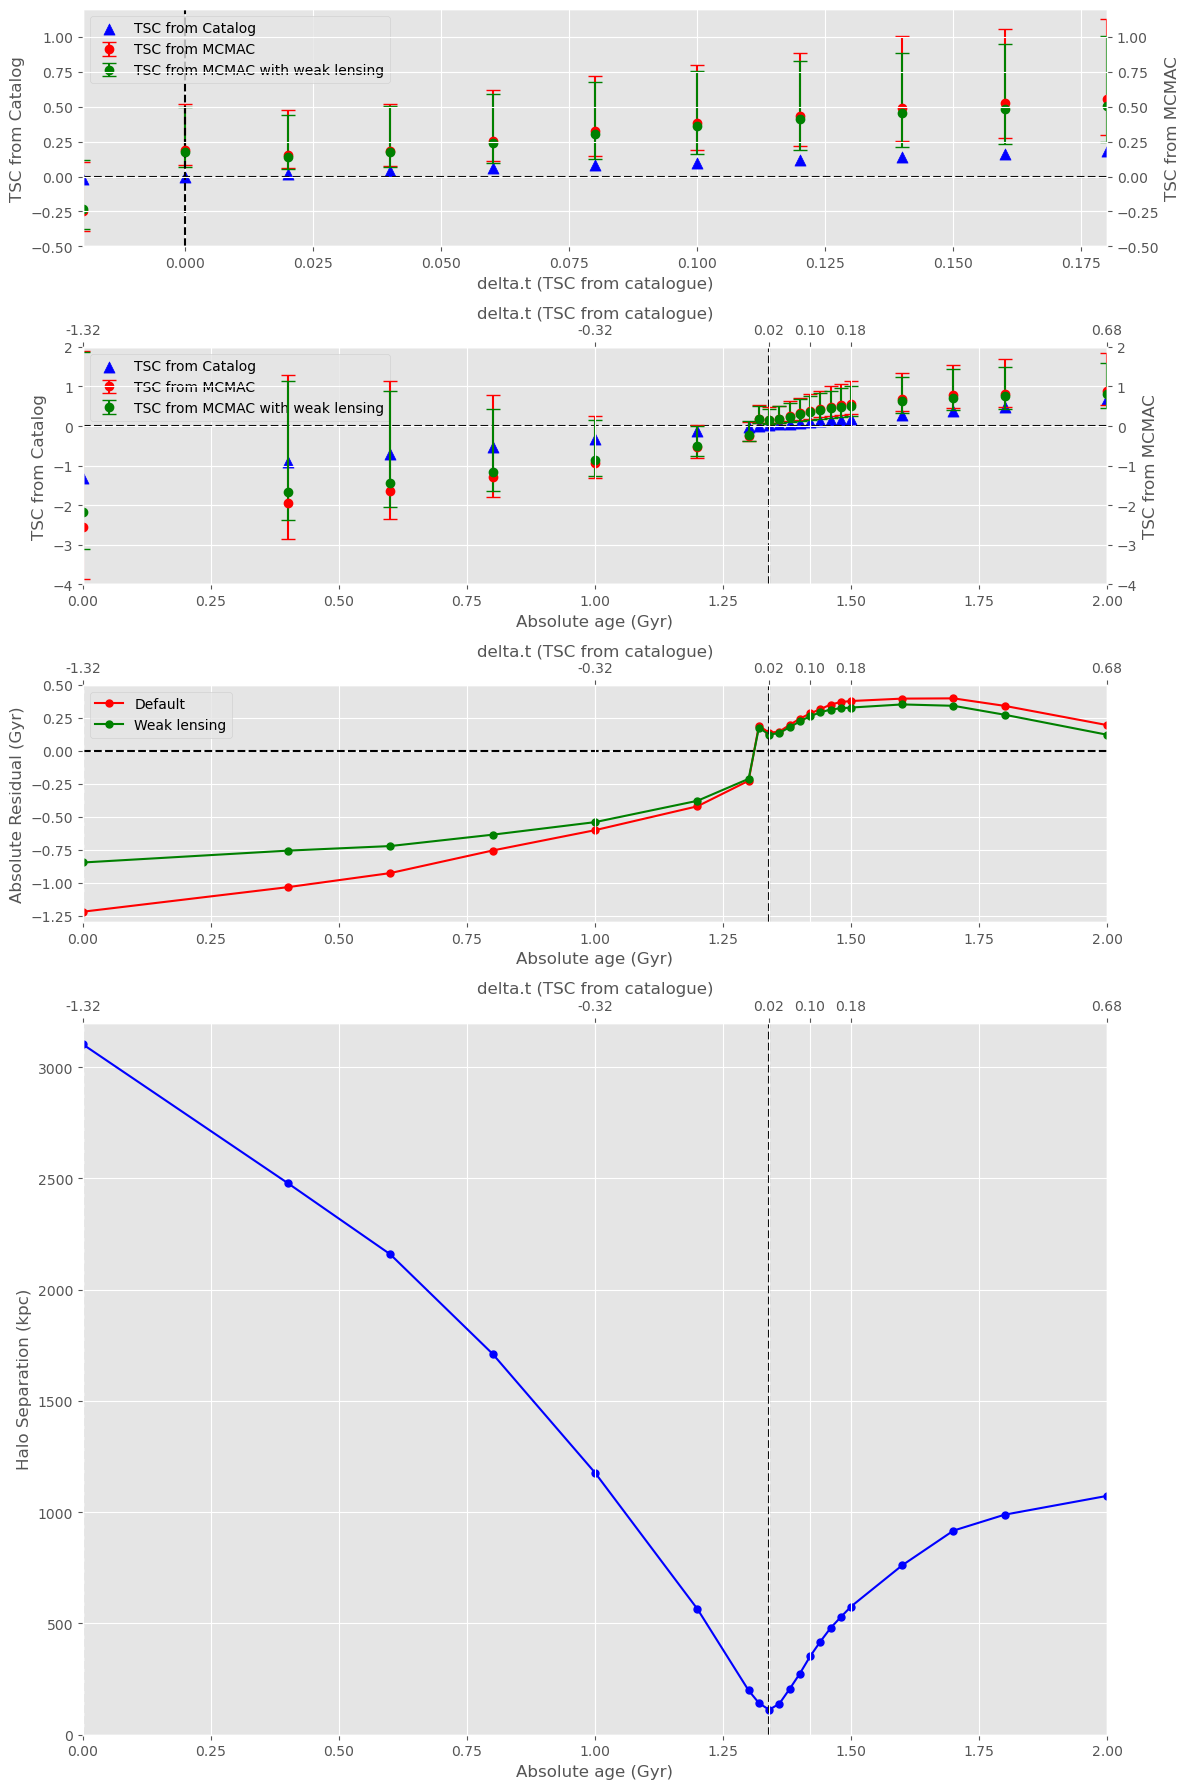

Metrics for default:
MAE: 0.4344384420334698
RMSE: 0.525937217260185
R²: -0.30431751011750685

Metrics for weak lensing bias:
MAE: 0.3586946792194349
RMSE: 0.4162828215170608
R²: 0.1828674791157301


In [5]:
filename_default = '../output_default/zh_1to1_b0.5_z_MCMAC.txt'
filename_20degree = '../output_weaklensing_bias/zh_1to1_b0.5_z_MCMAC.txt'

zoom_x_range = [-0.02, 0.18]
zoom_y_range = [-0.5, 1.2]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3200]
absolute_merge_time = 2 - 0.66

plotImage(filename_default, filename_20degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

## Mass ratio 1:1 b=1000kpc

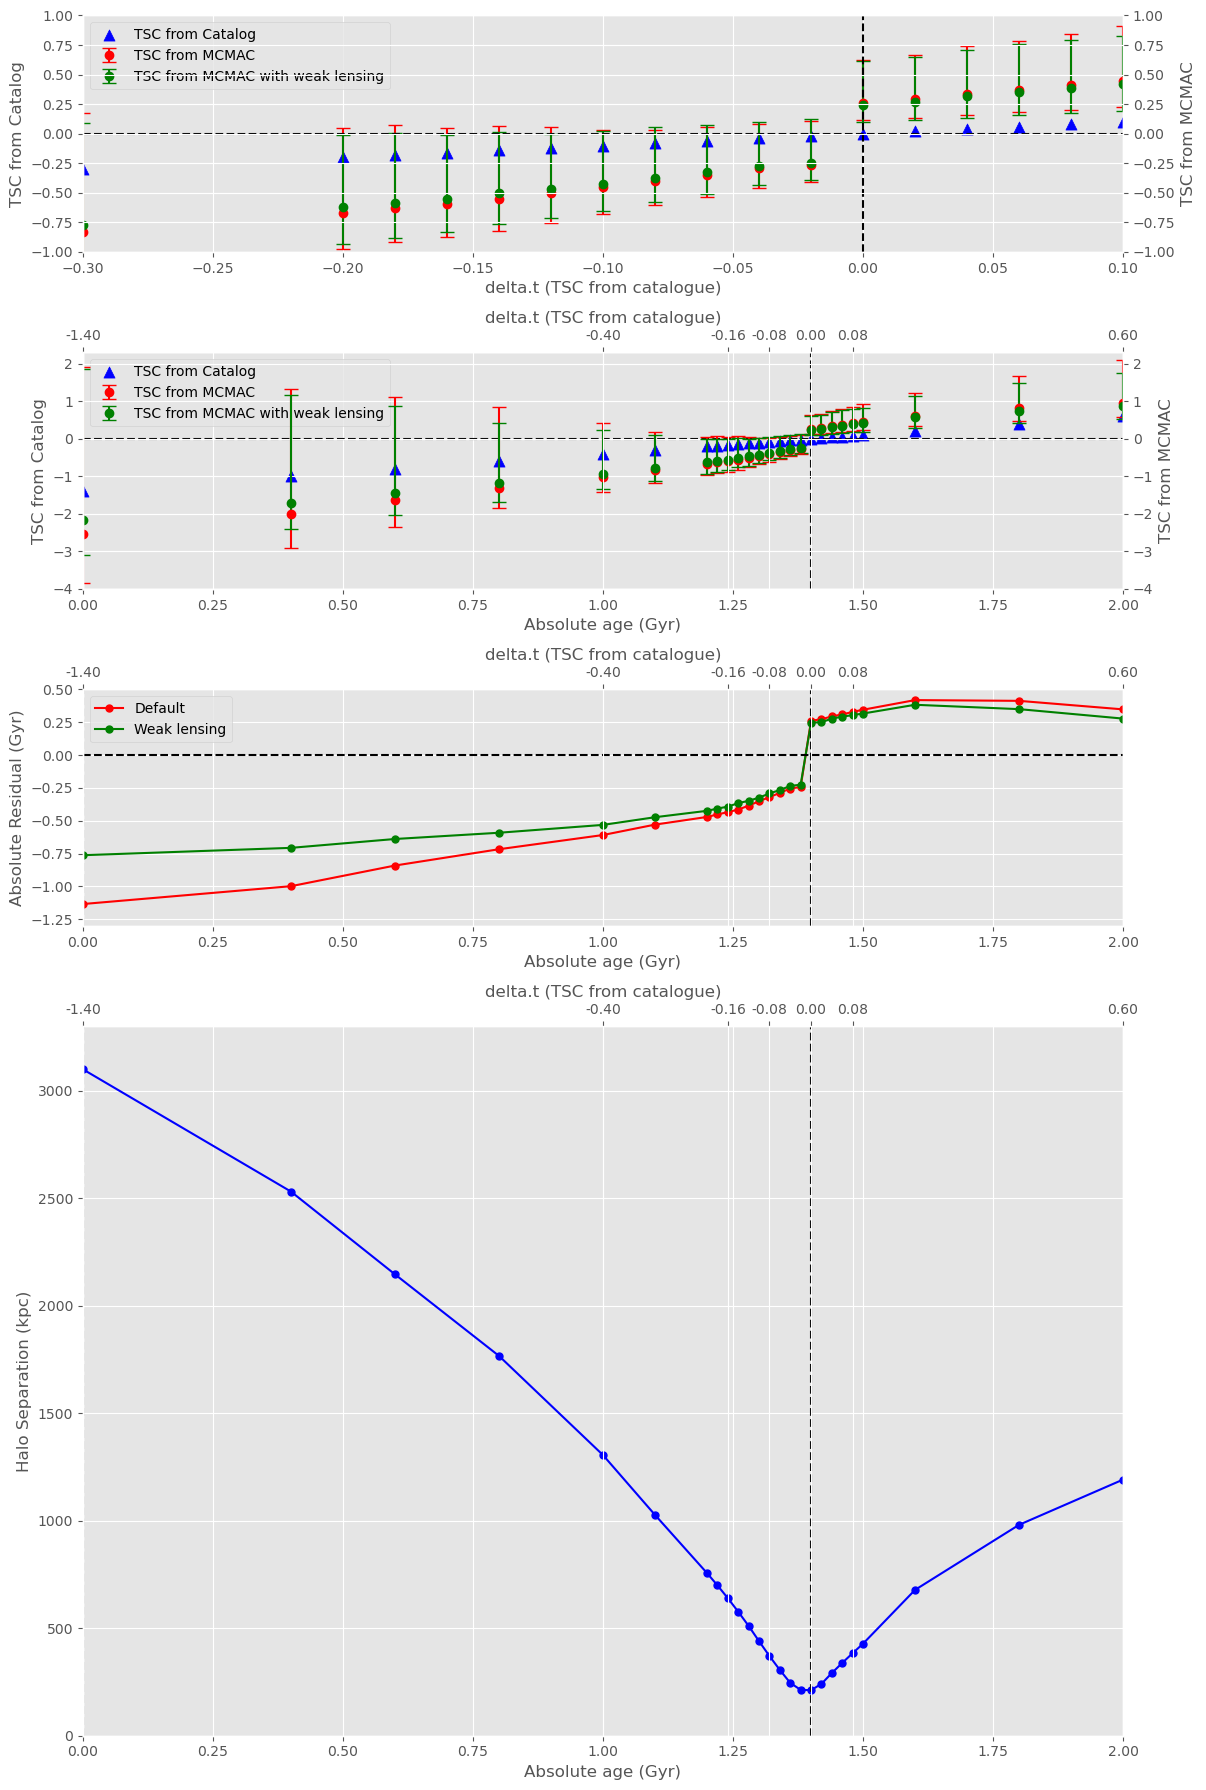

Metrics for default:
MAE: 0.45727297244428444
RMSE: 0.5113598841814035
R²: -0.5296759824855999

Metrics for weak lensing bias:
MAE: 0.3872022337550232
RMSE: 0.4141498711877281
R²: -0.003370201965624986


In [6]:
filename_default = '../output_default/zh_1to1_b1_z_MCMAC.txt'
filename_20degree = '../output_weaklensing_bias/zh_1to1_b1_z_MCMAC.txt'

zoom_x_range = [-0.3, 0.1]
zoom_y_range = [-1, 1]
plot1_x_range = [0, 2]
plot1_y_range = [-4, 2.3]
plot2_x_range = [0, 2]
plot2_y_range = [-1.3, 0.5]
plot3_x_range = [0, 2]
plot3_y_range = [0, 3300]
absolute_merge_time = 2 - 0.6

plotImage(filename_default, filename_20degree, zoom_x_range, zoom_y_range, plot1_x_range, plot1_y_range, plot2_x_range, plot2_y_range, plot3_x_range, plot3_y_range, absolute_merge_time)

In [7]:
# Convert results lists to dataframes
results_df_default = pd.DataFrame(results_default)
results_df_weaklensing = pd.DataFrame(results_weaklensing)

# Print the dataframes
print("Results for default:")
display(results_df_default)
print("\nResults for weak lensing:")
display(results_df_weaklensing)

average_improvement = {
    "MAE": results_df_default["MAE"].mean() - results_df_weaklensing["MAE"].mean(),
    "RMSE": results_df_default["RMSE"].mean() - results_df_weaklensing["RMSE"].mean(),
    "R²": results_df_weaklensing["R²"].mean() - results_df_default["R²"].mean()
}

print("Average Improvement")
print(average_improvement)

Results for default:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.422931,0.520465,-0.328451
1,1:1 (b=0.5),0.434438,0.525937,-0.304318
2,1:1 (b=1),0.457273,0.511360,-0.529676



Results for weak lensing:


,filename,MAE,RMSE,R²
0,1:1 (b=0),0.348712,0.409918,0.175942
1,1:1 (b=0.5),0.358695,0.416283,0.182867
2,1:1 (b=1),0.387202,0.414150,-0.003370


Average Improvement
{'MAE': 0.0733444634688028, 'RMSE': 0.10580351941537741, 'R²': 0.5059610102706924}
